# Homework 4
---

Released on Nov 26 -- due by *Dec 3, 11:59pm*.

In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.

Hand in your work by emailing the Jupyter notebook (please rename as "LASTNAME_FIRSTNAME.ipynb") to Anusri and myself.

---

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [1]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function

In [2]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
df.head()

,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,...,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,...,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,...,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,...,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,...,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,...,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [3]:
cells = list(df.columns[3:])
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

In [4]:
len(df.index)

5363

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(400000, 1000000)

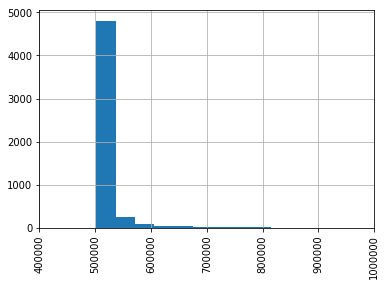

In [5]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

In [6]:
# TODO: insert code to print the min, median and max bin size
df['SIZE'] = df['END'] - df['START'] + 1
print('min: ', df['SIZE'].min())
print('median: ', df['SIZE'].median())
print('max: ', df['SIZE'].max())

min:  501688
median:  514870.0
max:  35387248


We retain bins with lengths between 450,000 and 500,000 using the following command.

In [7]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

In [8]:
# TODO: write code here to print unique list of values in 'CHR' column
print(df.CHR.unique())

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrX' 'chrY']


_Answer:_ male/female

Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.
### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

In [9]:
# TODO: insert code to generate a list of chromosome labels corresponding to autosomes, e.g. ['chr1', 'chr2', ...]
autosomes = [x for x in df.CHR.unique() if x not in ['chrX', 'chrY']]

In [10]:
len(df[df['CHR'].isin(autosomes)])

4718

_Answer:_ XXX bins

In [11]:
# we retain only autosomes
df = df[df['CHR'].isin(autosomes)]

Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112e57cc0>]],
      dtype=object)

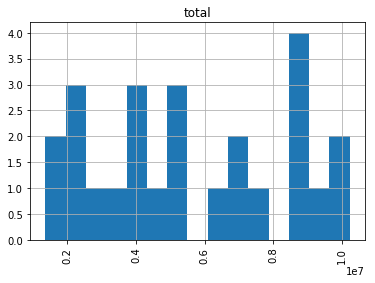

In [12]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df[cell].sum())) for cell in cells], columns=['cell', 'total'])
df_total_reads.hist(column="total", bins=15, xrot=90)

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 3,000,000 reads. Which six cells are excluded? [4 points]

In [13]:
cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])

In [14]:
# TODO: insert code to filter down to cells with less 3,000,000 reads
df_removed_cells = df_total_reads[df_total_reads['total'] < 3_000_000]

In [15]:
df_removed_cells

,cell,total
1,SRR054598,1784898
3,SRR054594,1361308
7,SRR053676,2036366
19,SRR053679,2021242
20,SRR054604,2473778
22,SRR053607,2784633


_Answer:_ 
1. XXX with YYY reads; 
2. XXX with YYY reads; 
3. XXX with YYY reads; 
4. XXX with YYY reads; 
5. XXX with YYY reads;
6. XXX with YYY reads.

In [16]:
# we retain only cells with >= 300,000 reads
df = df[list(df.columns)[:3] + cells_to_keep]

The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

In [17]:
nr_bins = 20
df2 = df.copy(deep=True)
for cell in cells_to_keep:
    # insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
    largest = df[cell].max()
    bin_size = largest // nr_bins
    df2[cell] = (df[cell] // bin_size) * bin_size
df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode())) for cell in cells_to_keep], 
                                    columns=['cell', 'mode'])

In [18]:
# TODO: insert code to divide each read count by the mode of the corresponding cell
for cell in cells_to_keep:
    df[cell] = df[cell] / df_mode[df_mode.cell == cell]['mode'].iloc[0]

In [19]:
# The following commented out code generates data_filtered.tsv, which is part of the zip file of this assignment. 
# If your code is correct the resulting file should be identical to the provided file.
df.to_csv("data_filtered_normalized2.tsv", sep="\t")

## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [20]:
df_norm = pd.read_table("data_filtered_normalized.tsv", sep="\t", index_col=0)

In [21]:
df_norm.head()

,CHR,START,END,SRR089377,SRR053605,SRR089397,SRR054614,SRR089402,SRR053633,SRR053617,...,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053611,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
2,chr1,1833663,2345598,0.888386,1.098485,0.952244,0.826198,5.522936,1.115029,1.055882,...,0.805381,3.628364,1.122470,1.290146,0.922043,1.070175,4.304422,0.945455,1.093583,0.813095
4,chr1,2946627,3452945,1.100553,1.114899,1.197353,0.597859,4.938838,1.034682,1.147059,...,0.765919,3.318841,0.974696,1.253650,0.921371,1.245614,5.501701,0.792929,1.048128,0.721429
6,chr1,4112609,4622985,1.231272,1.155303,1.207135,0.780836,6.683996,1.348555,1.276471,...,0.947982,4.175983,1.065789,1.293796,0.936828,1.454545,5.103741,1.136364,1.172460,0.783929
7,chr1,4622984,5133470,1.047763,1.053030,1.133487,0.804791,5.490316,1.136994,1.087255,...,0.844843,3.906832,1.135628,1.458029,0.807124,1.275120,4.784014,1.095960,1.085561,0.749405
8,chr1,5133469,5640704,1.002514,1.183081,1.288838,0.734455,5.291539,1.271098,1.126471,...,0.764126,3.367495,1.229757,1.177007,0.667339,1.310207,4.250000,1.048485,1.192513,0.952976


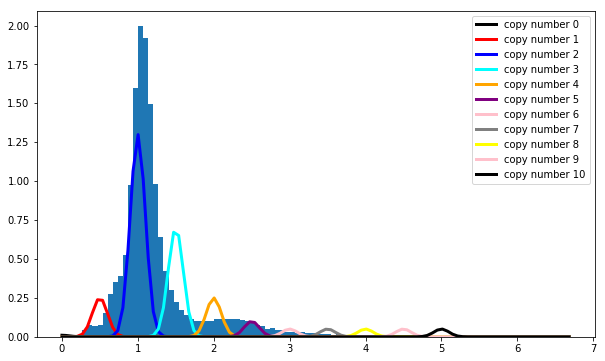

In [22]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, 100, density=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [23]:
from scipy.stats import norm
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)  
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)
    
    # prevent probability of 0
    prob = max(up - low, 0.0001)
    
    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [24]:
for cell in list(df_norm.columns[3:]):
    log_prob = 0
    for idx, norm_count in df_norm[cell].iteritems():
        # TODO: insert code here
        # Hint: idx == 0 is the initial item.
        if idx == 0:
            log_prob = initialLogProb(2) + emissionLogProb(2, norm_count)
        else:
            log_prob += transitionLogProb(2, 2) + emissionLogProb(2, norm_count)
    
    print(cell, log_prob)

SRR089377 -15219.789046840733
SRR053605 -15578.100682201888
SRR089397 -15341.89317914691
SRR054614 -28486.442059180677
SRR089402 -37689.64042528754
SRR053633 -17980.665275592724
SRR053617 -16591.83324736538
SRR054608 -28629.646253643343
SRR053608 -17018.88489979599
SRR054602 -29999.56321734497
SRR089401 -35737.275021497466
SRR053668 -23687.561122802355
SRR054606 -36758.68301171966
SRR054613 -28302.29275709495
SRR053631 -21786.499207109642
SRR054575 -34594.39115384095
SRR053611 -15430.556501784851
SRR053602 -18423.853700046162
SRR054610 -28584.287624901153


### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

_Hint:_ Complete the function `viterbi` and `max_joint_prob`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [25]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        
        # TODO: Insert code here
        for copy_number in range(max_copy_number + 1):
            if idx == 0:
                v[copy_number][bin] = initialLogProb(copy_number) + emissionLogProb(copy_number, norm_count)
            else:
                prev_bin = bins[idx - 1]
                v[copy_number][bin] = (max((transitionLogProb(prev_copy_num, copy_number) + v[prev_copy_num][prev_bin])
                                          for prev_copy_num in range(max_copy_number+1)) + 
                                       emissionLogProb(copy_number, norm_count))

    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # TODO: insert code here
    return max(v[q][last_bin] for q in Q)

V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -15222.186932117167
SRR053605 -- max prob: -15580.498567475632
SRR089397 -- max prob: -15344.291064419494
SRR054614 -- max prob: -21289.82450399119
SRR089402 -- max prob: -26942.479702890607
SRR053633 -- max prob: -17983.063160867947
SRR053617 -- max prob: -16594.231132637036
SRR054608 -- max prob: -21910.80865374336
SRR053608 -- max prob: -17021.28278506982
SRR054602 -- max prob: -22063.759590752143
SRR089401 -- max prob: -25818.240915559247
SRR053668 -- max prob: -18020.83116087692
SRR054606 -- max prob: -25662.033411590968
SRR054613 -- max prob: -21771.92762904439
SRR053631 -- max prob: -21664.21110372792
SRR054575 -- max prob: -26713.52799125626
SRR053611 -- max prob: -15432.954387058015
SRR053602 -- max prob: -18421.59688767269
SRR054610 -- max prob: -21846.251133649464


### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [26]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        # TODO: insert code here
        norm_count = float(df.loc[bin][cell])
        for copy_number in range(max_copy_number + 1):
            if idx == 0:
                v[copy_number][bin] = initialLogProb(copy_number) + emissionLogProb(copy_number, norm_count)
            else:
                prev_bin = bins[idx - 1]
                log_probs = np.array([(transitionLogProb(prev_copy_num, copy_number) + v[prev_copy_num][prev_bin])
                                      for prev_copy_num in range(max_copy_number+1)])
                v[copy_number][bin] = np.max(log_probs) + emissionLogProb(copy_number, norm_count)
                bt[copy_number][bin] = np.argmax(log_probs)
    return v, bt

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
for cell in list(df_norm.columns[3:]):
    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}
    
    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c
    
    C[cell][final_bin] = final_c
    
    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]
    
    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -15222.186932117167
SRR053605 -- max prob: -15580.498567475632
SRR089397 -- max prob: -15344.291064419494
SRR054614 -- max prob: -21289.82450399119
SRR089402 -- max prob: -26942.479702890607
SRR053633 -- max prob: -17983.063160867947
SRR053617 -- max prob: -16594.231132637036
SRR054608 -- max prob: -21910.80865374336
SRR053608 -- max prob: -17021.28278506982
SRR054602 -- max prob: -22063.759590752143
SRR089401 -- max prob: -25818.240915559247
SRR053668 -- max prob: -18020.83116087692
SRR054606 -- max prob: -25662.033411590968
SRR054613 -- max prob: -21771.92762904439
SRR053631 -- max prob: -21664.21110372792
SRR054575 -- max prob: -26713.52799125626
SRR053611 -- max prob: -15432.954387058015
SRR053602 -- max prob: -18421.59688767269
SRR054610 -- max prob: -21846.251133649464


### _Q2d:_ Which cells are normal cells (i.e. have copy number 2 for each bin)? [10 points]

_Hint:_ Use `visualizeCopyNumbers(C, bins)`.

_Answer:_ XXX

In [27]:
bins = sorted(list(df_norm.index))

In [28]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), C[cell].values())
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

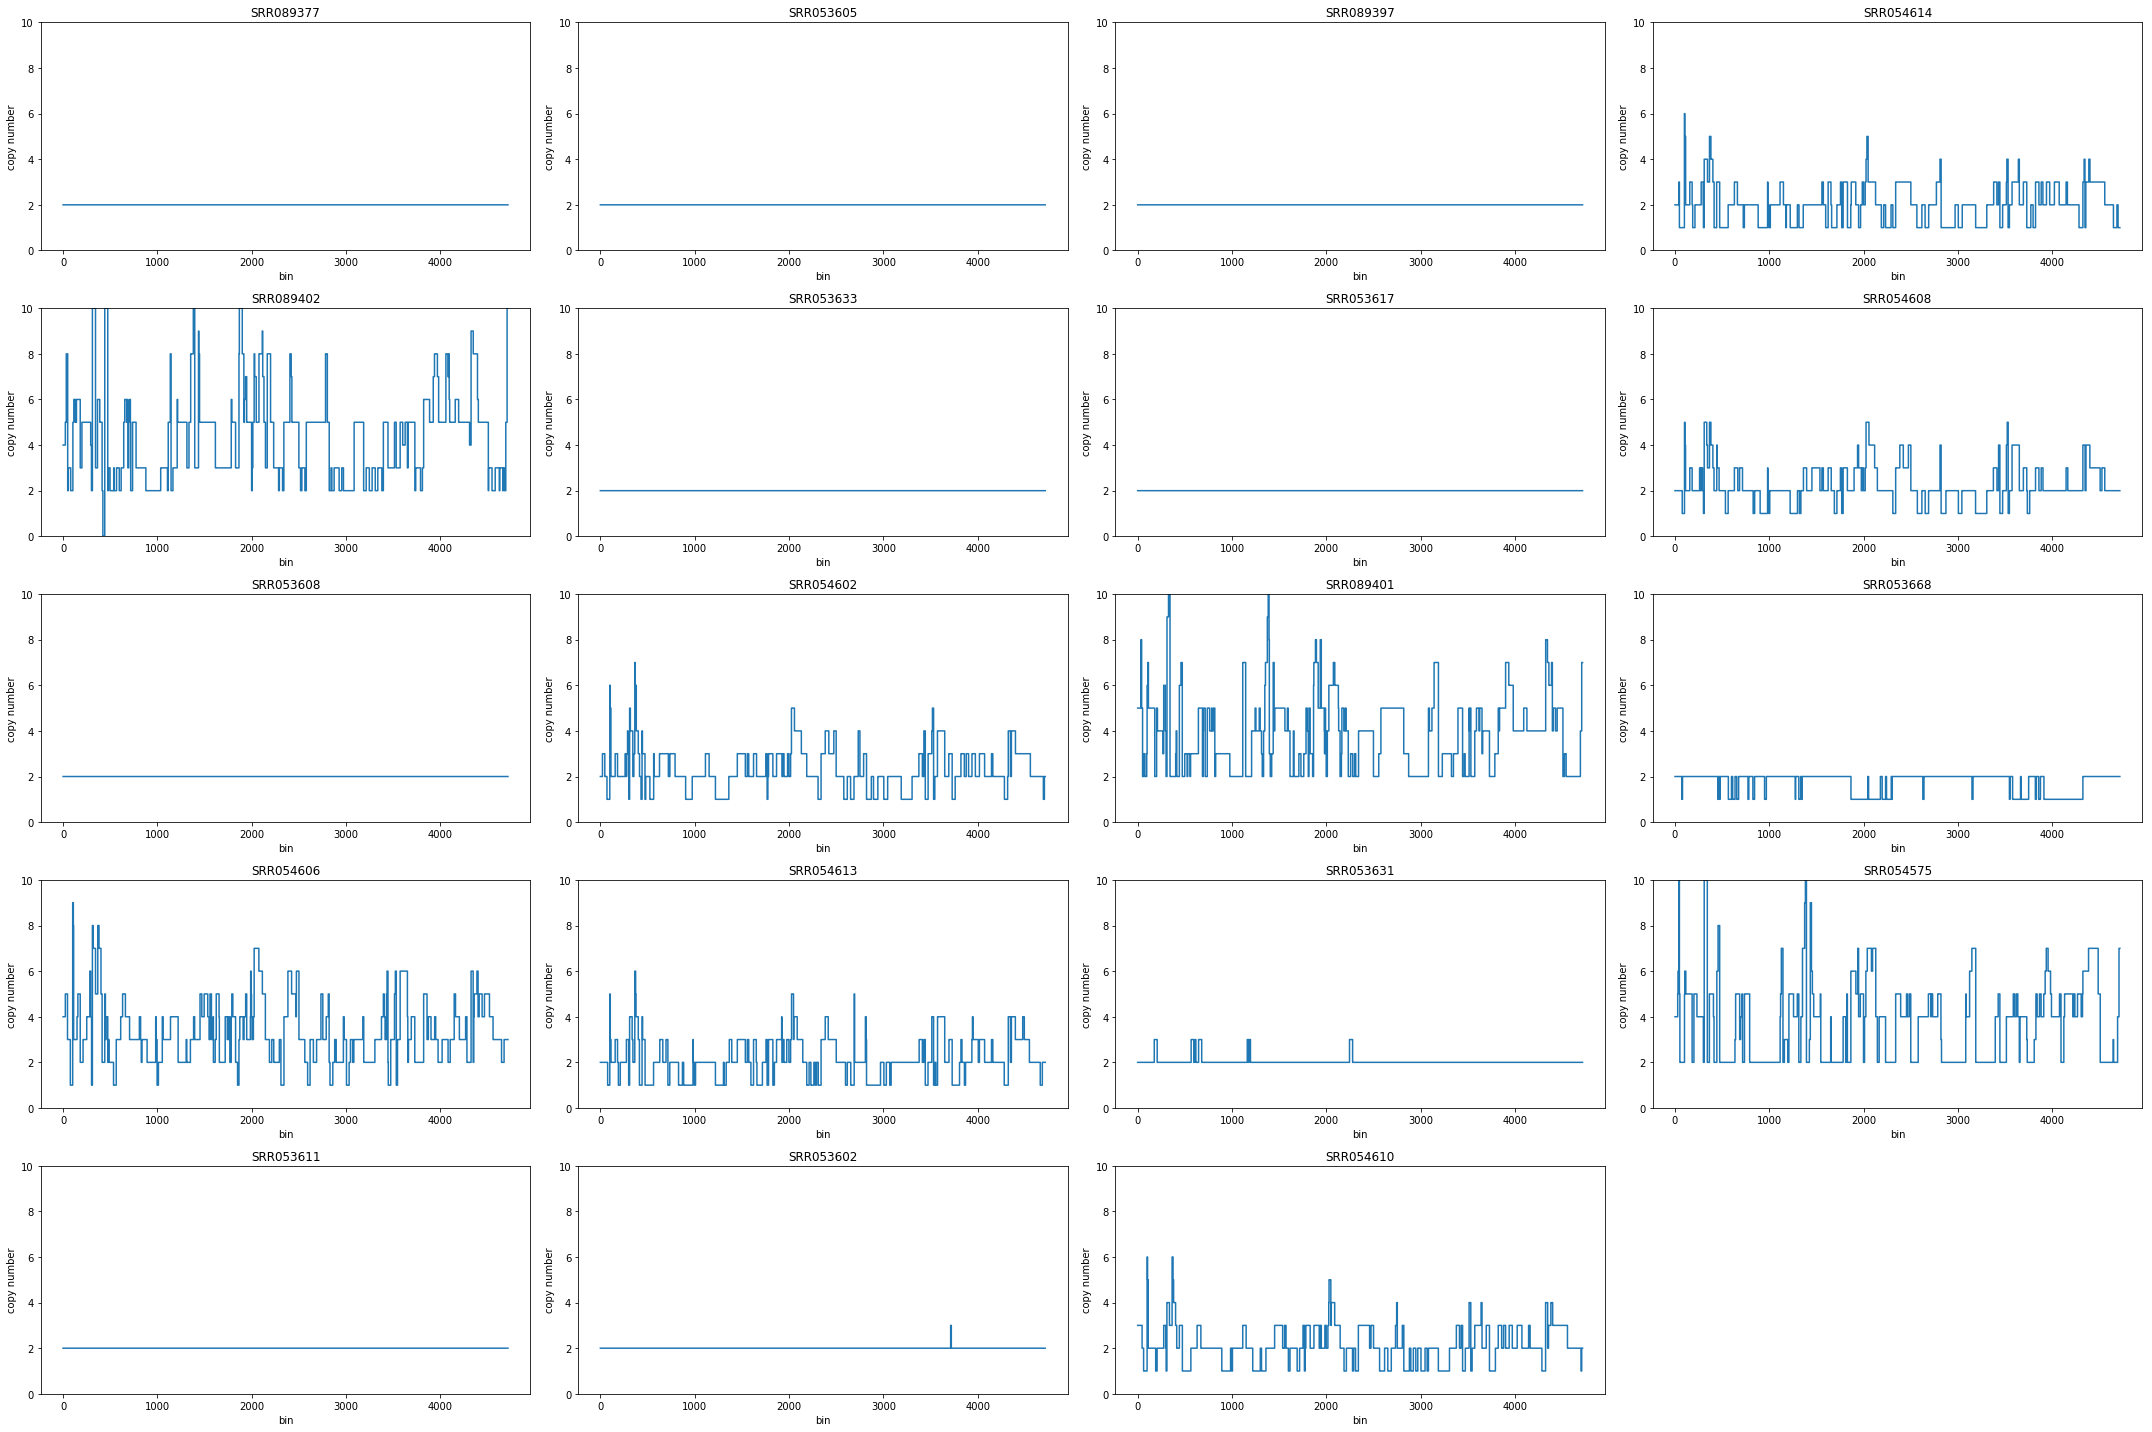

In [29]:
visualizeCopyNumbers(C, bins)

### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines. Do not forget to update x-axis labels to show chromosomes. [5 points]

In [109]:
def visualizeChromosomalCopyNumbers(C, bins, df):
    nrRows = 20
    nrCols = 1

    for idx, cell in enumerate(C):
        ch = None
        ticks = []
        ticklabels = []
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), C[cell].values())
        
        for i, bin in enumerate(bins):
            if df.CHR[bin] != ch:
                if ch is not None:
                    plt.axvline(x=i)
                ch = df.CHR[bin]
                ticks.append(i)
                ticklabels.append(ch)
        ticks.append(len(bins))
        ticks = np.array(ticks)
        ticks = (ticks[1:] + ticks[:-1]) / 2
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("chromosome")
        ax.set_ylabel("copy number")
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
    plt.gcf().set_size_inches(30, 100)
    plt.tight_layout()
    plt.savefig("viterbi-chromosomal.pdf")

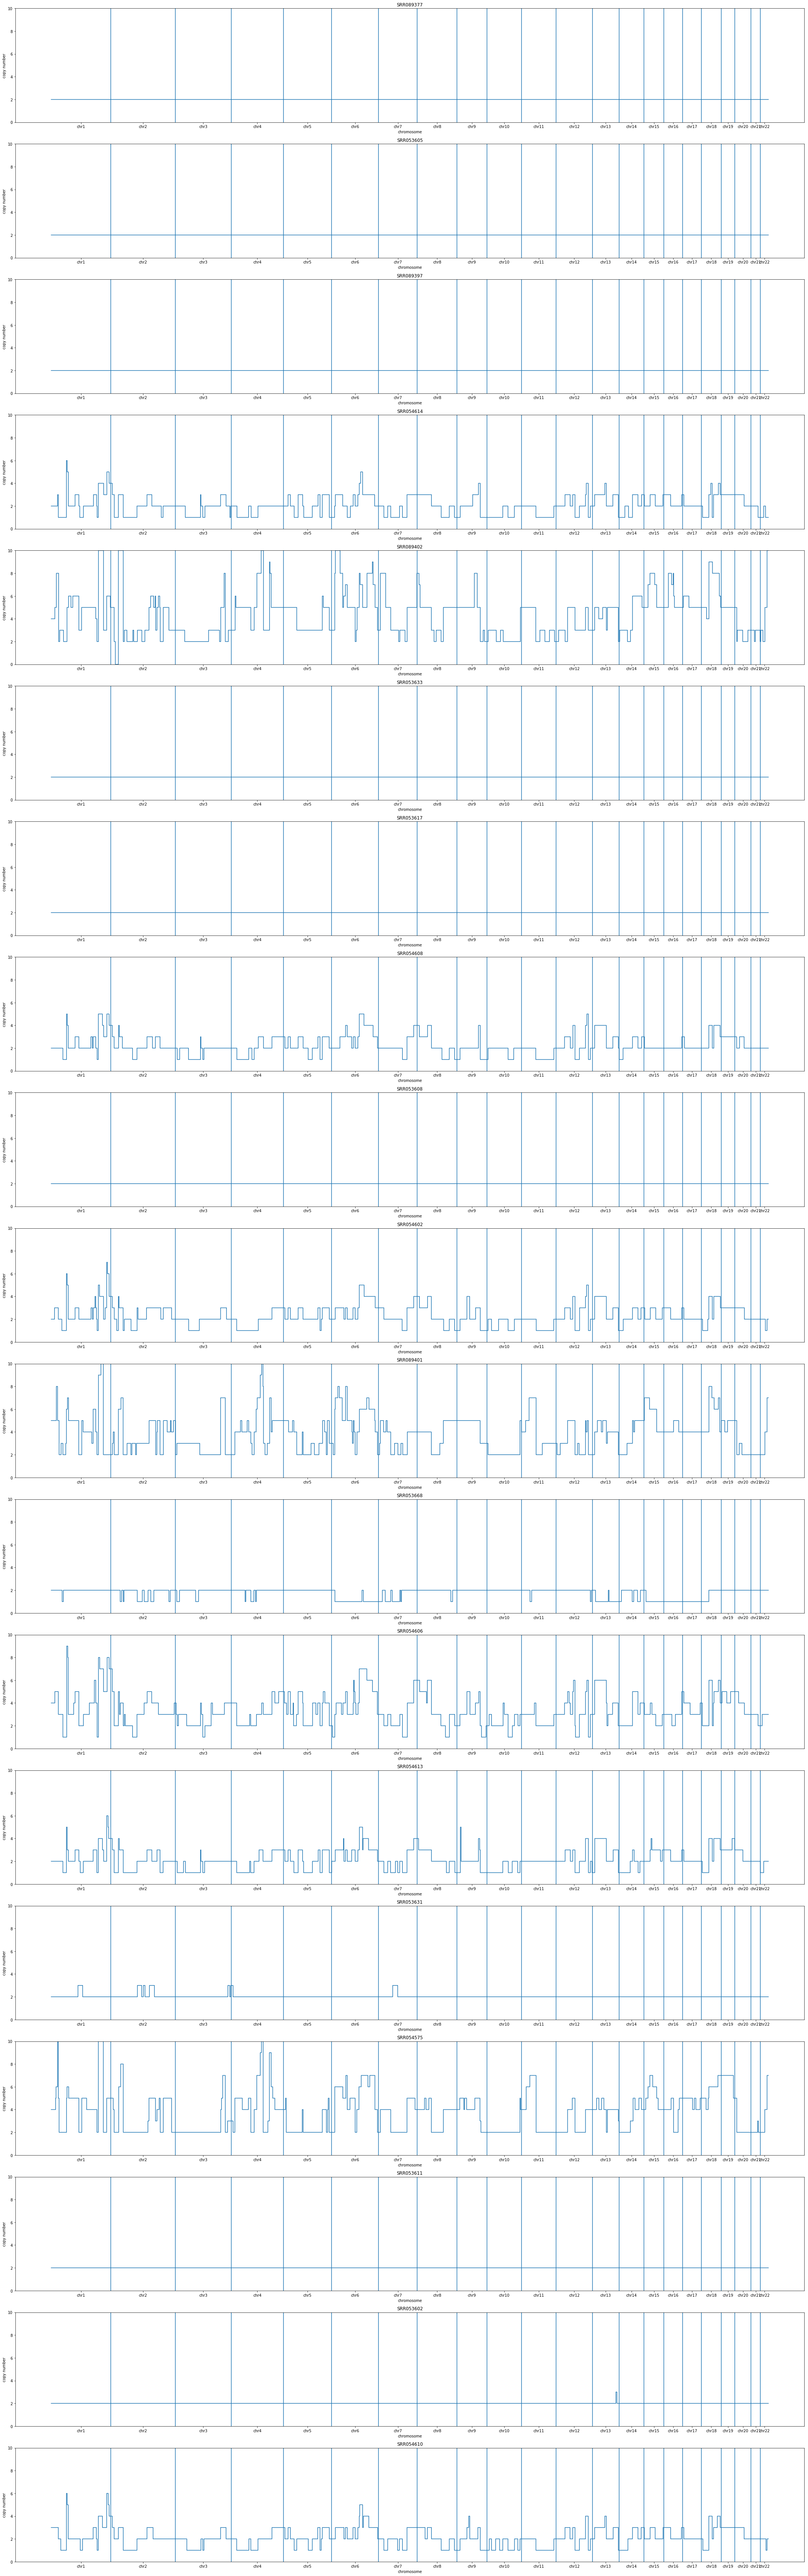

In [110]:
visualizeChromosomalCopyNumbers(C, bins, df)

## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]
_Hint:_ Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

In [30]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        
        # TODO: insert code here
        for s in Q:
            if idx == 0:
                f[s][bin] = initialLogProb(s) + emissionLogProb(s,norm_count)
            else:
                prev_bin = bins[idx - 1]
                
                logs = [transitionLogProb(t, s) + f[t][prev_bin] for t in Q]
                scale = max(logs) 
                scaled_sum = np.log(sum(np.exp(logs[i] - scale) for i in range(len(logs))))
                actual_sum = scaled_sum + scale
                
                f[s][bin] = actual_sum + emissionLogProb(s, norm_count)

    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # insert code here
    return sum(f[s][last_bin] for s in Q)

F = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    print(cell, "--", "marginal log prob:", marginal_log_prob(df_norm, F[cell]))

SRR089377 -- marginal log prob: -167642.89090889288
SRR053605 -- marginal log prob: -171574.44771118023
SRR089397 -- marginal log prob: -168991.61035543305
SRR054614 -- marginal log prob: -234022.28091308256
SRR089402 -- marginal log prob: -295806.95192598633
SRR053633 -- marginal log prob: -197988.79222298006
SRR053617 -- marginal log prob: -182668.0849756113
SRR054608 -- marginal log prob: -240861.31751202414
SRR053608 -- marginal log prob: -187410.6244483134
SRR054602 -- marginal log prob: -242552.1549625403
SRR089401 -- marginal log prob: -283477.74422791885
SRR053668 -- marginal log prob: -198348.07740764177
SRR054606 -- marginal log prob: -281771.52120869985
SRR054613 -- marginal log prob: -239253.5288256829
SRR053631 -- marginal log prob: -238451.76062965207
SRR054575 -- marginal log prob: -293344.18382764596
SRR053611 -- marginal log prob: -169965.48748000973
SRR053602 -- marginal log prob: -202819.01914685965
SRR054610 -- marginal log prob: -240064.03294499495


## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [31]:
C_values = [list(C[cell].values()) for cell in C]
C_labels = list(C.keys())

[[0.000e+00 1.000e+00 0.000e+00 2.000e+00]
 [2.000e+00 1.900e+01 0.000e+00 3.000e+00]
 [5.000e+00 2.000e+01 0.000e+00 4.000e+00]
 [6.000e+00 2.100e+01 0.000e+00 5.000e+00]
 [8.000e+00 2.200e+01 0.000e+00 6.000e+00]
 [1.600e+01 2.300e+01 0.000e+00 7.000e+00]
 [1.700e+01 2.400e+01 7.000e+00 8.000e+00]
 [1.400e+01 2.500e+01 1.630e+02 9.000e+00]
 [3.000e+00 1.800e+01 8.350e+02 2.000e+00]
 [7.000e+00 9.000e+00 9.330e+02 2.000e+00]
 [2.700e+01 2.800e+01 9.920e+02 4.000e+00]
 [1.300e+01 2.900e+01 1.144e+03 5.000e+00]
 [1.100e+01 2.600e+01 1.207e+03 1.000e+01]
 [3.000e+01 3.100e+01 2.545e+03 1.500e+01]
 [1.000e+01 1.500e+01 2.993e+03 2.000e+00]
 [4.000e+00 3.300e+01 3.968e+03 3.000e+00]
 [1.200e+01 3.200e+01 4.926e+03 1.600e+01]
 [3.400e+01 3.500e+01 5.780e+03 1.900e+01]]


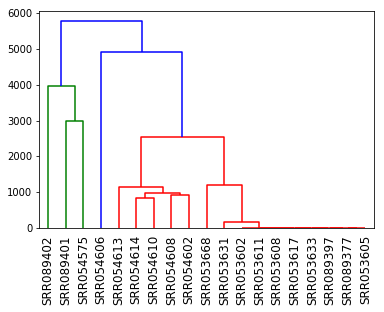

In [65]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
print(Z)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [34]:
def manhattan(C, cell_1, cell_2, bins):
    # TODO: insert code here
    v1 = C[cell_1]
    v2 = C[cell_2]
    return sum(abs(v1[bin] - v2[bin]) for bin in bins)

bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C_labels:
    dist[cell_1] = {}
    for cell_2 in C_labels:
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [76]:
import copy
def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = list(distances.keys())
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: insert code to identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = np.inf, None, None
#         for cluster1 in clusters:
#             for cluster2 in clusters:
        for cluster1 in idx2cluster:
            for cluster2 in idx2cluster:
                if cluster1 in clusters and cluster2 in clusters:
                    if cluster1 == cluster2:
                        continue
                    if distances[cluster1][cluster2] < dist:
                        dist = distances[cluster1][cluster2]
                        c1 = cluster1
                        c2 = cluster2
                
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = n + len(Z)
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        
        # TODO: insert code to update distances
        distances[new_cluster] = {}
        distances[new_cluster][new_cluster] = 0
        for cluster in clusters:
#             print(c1, c2, cluster)
            d = min(distances[c1][cluster], distances[c2][cluster])
            distances[new_cluster][cluster] = d
            distances[cluster][new_cluster] = d
        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
        
    return Z

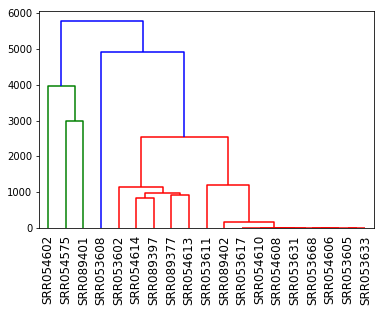

In [77]:
Z = cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

### _Q4c -- Bonus:_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

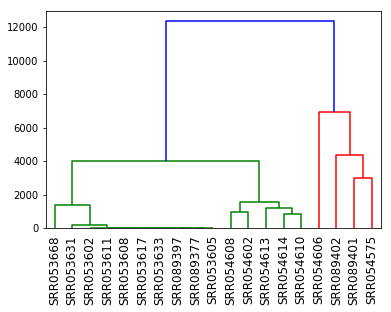

In [78]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

In [79]:
import copy
def complete_linkage_cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = list(distances.keys())
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: insert code to identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = np.inf, None, None
#         for cluster1 in clusters:
#             for cluster2 in clusters:
        for cluster1 in idx2cluster:
            for cluster2 in idx2cluster:
                if cluster1 in clusters and cluster2 in clusters:
                    if cluster1 == cluster2:
                        continue
                    if distances[cluster1][cluster2] < dist:
                        dist = distances[cluster1][cluster2]
                        c1 = cluster1
                        c2 = cluster2
                
        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = n + len(Z)
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        
        # TODO: insert code to update distances
        distances[new_cluster] = {}
        distances[new_cluster][new_cluster] = 0
        for cluster in clusters:
#             print(c1, c2, cluster)
            d = max(distances[c1][cluster], distances[c2][cluster])
            distances[new_cluster][cluster] = d
            distances[cluster][new_cluster] = d
        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
        
    return Z

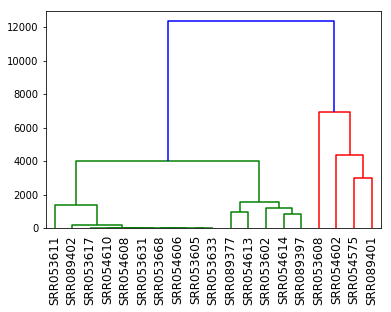

In [111]:
Z = complete_linkage_cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)